In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import numpy as np
import os
import glob
import pickle
from operator import itemgetter
from Bio import SeqIO
import csv
import scipy
from scipy import stats
import pybedtools
from matplotlib_venn import venn3, venn3_circles,venn3_unweighted,venn2
import seaborn as sns
from pandas import DataFrame
import matplotlib.patches as patches


# Initializtion

In [3]:
tool="HISAT2"
sample="NA12878"
callers="GATK"
assemblers="StringTie"
editor="GIREMI"


varsim_jar="/path/to/VarSim.jar"
NIST_HC_nonDB="/path/to/NIST_HC_nonDB.vcf"
NIST_HC_vcf="/path/to/NIST_HC.vcf"
b37_regions="/path/to/b37_regions"
b37_rmask_bed="/path/to/b37.rmask.bed"




# Predictions

In [4]:


pred_file="/path/to/giremi_out_good.txt.res"
pred_file_pcnt_hidden={i:"/path/to/giremi_out_good_%s.txt.res"%i 
                       for i in range(10,110,10)}


# Funcions

In [5]:
def parse_giremi(outfile):
    preds=[]
    with open(outfile,"r") as csv_file:
        spamreader = csv.reader(csv_file, delimiter='\t', quotechar='|')
        cnt=0
        for row in spamreader:
            if cnt==0:
                cnt=1
                continue
            preds.append(row)
    return preds

In [6]:
def parse_ga(outfile):
    preds=[]
    llrs=[]
    with open(outfile,"r") as csv_file:
        spamreader = csv.reader(csv_file, delimiter='\t', quotechar='|')
        cnt=0
        for row in spamreader:
            x=row
            if int(x[1])==int(x[5]) and int(x[1])==(int(x[4])+1) and (x[2]==x[9]) and (x[3]==x[10]):
                keys=x[11].split(":")
                vals=x[12].split(":")
                if "AD" not in keys:
                    cnts=["1","1"]
                else:
                    cnts=vals[keys.index("AD")].split(",")
                if int(cnts[0])==0:
                    continue
            preds.append([x[0],x[1],x[2],x[3],x[6],x[7],cnts[0],cnts[1]])
    print len(preds)
    return preds

In [7]:
def vcf_to_bed(vcf_file,all_otherfields=False,otherfields=[]):
    with open(vcf_file,"r") as csv_file:
        spamreader = csv.reader(csv_file, delimiter='\t', quotechar='|')
        intervals=[]
        for row in spamreader:
            if row[0]=="#":
                continue
            if all_otherfields:
                otherfields=range(2,len(row))
            if otherfields:
                intervals.append(pybedtools.Interval(row[0],int(row[1])-1,int(row[1]),otherfields=[row[i]
                                                                                        for i in otherfields]))
            else:
                intervals.append(pybedtools.Interval(row[0],int(row[1])-1,int(row[1])))                
    return pybedtools.BedTool(intervals)    

In [8]:
def find_etype(ref,alt,strand):
    revnt={"A":"T","C":"G","T":"A","G":"C"}
    if strand=="-":
        alt=revnt[alt]
        ref=revnt[ref]
    return ref+alt


In [9]:
def find_er(ref,alt,strand,counts):
    revnt={"A":"T","C":"G","T":"A","G":"C"}
    id_n={"A":0,"C":1,"G":2,"T":3}
    counts=map(int,counts)
    if strand=="-":
        alt=revnt[alt]
        ref=revnt[ref]
    eratio=int(counts[id_n[alt]]/float(sum(counts))*100)
    return eratio
    
    
    

In [10]:
revnt={"A":"T","C":"G","T":"A","G":"C"}
def giremi_to_vcf(giremi_list,vcf_file):
    with open(vcf_file,"w") as csv_file:
        spamwriter = csv.writer(csv_file, delimiter='\t', quotechar='|')
        for x in giremi_list:
            if int(x[22])==0:
                continue
            ref,alt=x[17][0],x[17][1]
            strand=x[3]
            if strand=="-":
                alt=revnt[alt]
                ref=revnt[ref]
            spamwriter.writerow([x[1],x[2],".",ref,alt,".","PASS","."])


In [11]:
revnt={"A":"T","C":"G","T":"A","G":"C"}
def ga_to_vcf(ga_list,vcf_file):
    with open(vcf_file,"w") as csv_file:
        spamwriter = csv.writer(csv_file, delimiter='\t', quotechar='|')
        for x in ga_list:
            spamwriter.writerow([x[0],x[1],".",x[2],x[3],".","PASS","."])


In [12]:
revnt={"A":"T","C":"G","T":"A","G":"C"}


In [13]:
Alu_regions=pybedtools.BedTool(b37_rmask_bed
                      ).filter(lambda x: "Alu" in x.name).merge().sort()
print len(Alu_regions)

1076670


In [14]:
reps=["repeats_b37_duplicates.bed","repeats_b37_Low_complexity.bed","repeats_b37_SINE.bed",
"repeats_b37_duplicates_unique.bed", "repeats_b37_Satellite.bed", "repeats_b37_LINE.bed", "repeats_b37_Simple_repeat.bed"]
rep_regions=pybedtools.BedTool([])
for rep in reps:
    rep_regions=rep_regions.cat("%s/%s"%(b37_regions,rep))
rep_regions=rep_regions.sort().merge()

In [15]:
nonAlu_rep_regions=rep_regions.subtract(Alu_regions).sort()

In [16]:
vcf_file="%s.vcf"%pred_file
editor_pred=parse_giremi(pred_file)
giremi_to_vcf(editor_pred,vcf_file)
editor_bed=vcf_to_bed(vcf_file,all_otherfields=True)
cmd="java -jar  %s vcfcompare -true_vcf %s -prefix \
%s.NISTHCnonDB %s"%(varsim_jar,NIST_HC_nonDB,pred_file,vcf_file)
if not os.path.exists("%s.NISTHCnonDB_TP.vcf"%(pred_file)):
    a=os.system(cmd)
    print cmd
    if a!=0:
        print a

In [17]:
pred_edited={}
edit_bed=pybedtools.BedTool([pybedtools.Interval(x[1],int(x[2])-1,int(x[2]),x[17],find_er(x[17][0],x[17][1],x[3],x[18:22])) 
                             for x in editor_pred if int(x[22])>0])                
for region,region_bed in [["Alu",Alu_regions],["nonAlu-reps",nonAlu_rep_regions],["nonreps",""],["all",""]]:
    if region in ["Alu","nonAlu-reps"]:
        my_edit_bed=edit_bed.window(region_bed,w=0,u=True)
    elif region=="nonreps":
        my_edit_bed=edit_bed.window(Alu_regions,w=0,v=True)
        my_edit_bed=my_edit_bed.window(nonAlu_rep_regions,w=0,v=True)
    elif region=="all":
        my_edit_bed=edit_bed.sort()
    edit_types=[x[3] for x in my_edit_bed]
    edit_ratios=[x[4] for x in my_edit_bed]
    vcf_file="%s.NISTHCnonDB_TP.vcf"%pred_file
    NIST_errors=len(vcf_to_bed(vcf_file))
    pred_edited[region]={
        "dist":{etype:edit_types.count(etype) for etype in set(edit_types)},
        "ratio":edit_ratios,
        "types":edit_types,
        "errors":NIST_errors
    }

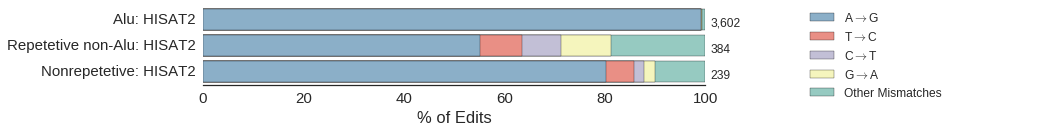

In [18]:
sns.set(style="white",font_scale=1.5)    
colors=[4]
nt=["A","C","G","T"]
etypes=[]
for i in nt:
    for j in nt:
        if i!=j:
            etypes.append(i+j)
rgn_name={"Alu": "Alu","nonAlu-reps":"Repetetive non-Alu","nonreps":"Nonrepetetive"}
bin_labels=[r"A$\rightarrow$G",r"T$\rightarrow$C",r"C$\rightarrow$T",r"G$\rightarrow$A","Other Mismatches"]
my_palette=sns.color_palette("Set3",n_colors=10)
fig, ax = plt.subplots(figsize=(9,1.4))        
res=[]
labels=[]
n={}
for rrr,rgn in enumerate(["Alu","nonAlu-reps","nonreps"]):                        
    my_dist=pred_edited
    if set(my_dist[rgn]["dist"].keys())-set(etypes):
        print aaaa
    z=[my_dist[rgn]["dist"][k] if k in 
       my_dist[rgn]["dist"] else 0 
       for k in etypes]

    sz=sum(z)+0.000001
    z=map(lambda x:round(x/float(sz),4)*100,z)
    z=[z[1],z[10],z[5],z[6],z[0]+sum(z[2:5])+sum(z[7:10])+z[11]]
    res_bin=[sum(z),sum(z[:4]),sum(z[:3]),sum(z[:2]),z[0]]
    res.append(res_bin)
    label="%s: %s"%(rgn_name[rgn], tool.replace("Tophat","TopHat"))
    n[label]=int(sz)
    labels.append(label)
my_data=DataFrame(np.array(res),index=labels,columns=bin_labels)
for ii,b in enumerate(bin_labels):
    cg=sns.barplot(data=my_data,x=b,y=labels,label=b, color=my_palette[ii],ax=ax)
for ii,label in enumerate(labels):
    ax.text(101,ii+.25,"%d,%03d"%(n[label]/1000,n[label]%1000) if n[label]>=1000 else n[label] ,fontsize=12)
ax.set_xlabel("% of Edits")
ax.set_xlim([0,100])
sns.despine(left=True)    
handles, labels = ax.get_legend_handles_labels()
# reverse the order
ax.legend(handles[::-1], labels,bbox_to_anchor=(1.2, 0.7, .5, .3), 
      loc=0,ncol=1,
      mode="expand", borderaxespad=0.,frameon=False,fontsize=12)

In [19]:
nist_editor_pred={}
nist_editor_bed={}
nist_editor_out={}
for x in range(0,110,10):
    if x==0:
        path=pred_file
    else:
        path=pred_file_pcnt_hidden[x]
    vcf_file="%s.vcf"%path
    nist_editor_out[x]=path
    nist_editor_pred[x]=parse_giremi(path)
    giremi_to_vcf(nist_editor_pred[x],vcf_file)
    nist_editor_bed[x]=vcf_to_bed(vcf_file,all_otherfields=True)
    cmd="java -jar %s  vcfcompare -true_vcf %s -prefix \
    %s.NISTHC_%s %s"%(varsim_jar,NIST_HC_vcf,path,x,vcf_file)
    if not os.path.exists("%s.NISTHC_%s_TP.vcf"%(path,x)):
        a=os.system(cmd)
        print cmd
        if a!=0:
            print a

In [20]:
FDR={"all_calls":[],"FPs":[],"FDR":[],"AG":[]}
for x in range(0,110,10):
    g=nist_editor_out[x]
    vcf_file="%s.NISTHC_%s_TP.vcf"%(g,x)
    NIST_errors=len(vcf_to_bed(vcf_file))
    all_calls=len(vcf_to_bed(vcf_file="%s.vcf"%g))
    fdr=NIST_errors/float(all_calls)*100
    FDR["all_calls"].append(all_calls)
    FDR["FPs"].append(NIST_errors)
    FDR["FDR"].append(fdr)
    edit_bed=pybedtools.BedTool([pybedtools.Interval(w[1],int(w[2])-1,int(w[2]),w[17],find_er(w[17][0],w[17][1],w[3],w[18:22])) 
                         for w in nist_editor_pred[x] if int(w[22])>0])                
    edit_types=[w[3] for w in edit_bed]
    dist={etype:edit_types.count(etype) for etype in set(edit_types)}
    FDR["AG"].append((dist["AG"])/float((all_calls))*100)


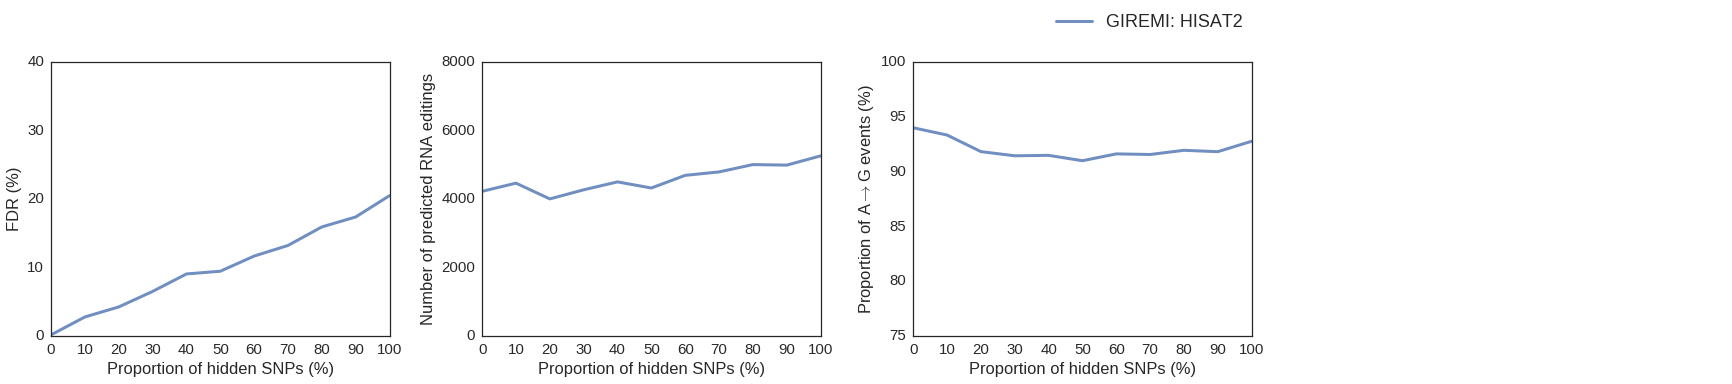

In [21]:
sns.set(style="white",font_scale=1.5)    
fig, axes = plt.subplots(1,3,figsize=(18,5))
hiddens=range(0,110,10)
for iii,key in enumerate(["FDR","all_calls","AG"]):
    ax=axes[iii]
    rects1 = ax.plot(hiddens,FDR[key],alpha=0.8,
                     label="%s: %s"%(editor,tool), linewidth=3)
    ax.set_xticks(range(0,110,10))
    ax.set_xlabel("Proportion of hidden SNPs (%)")
    if key=="FDR":
        ax.set_yticks(range(0,50,10))
        ax.set_ylim([0,40])
        ax.set_ylabel(r"FDR (%)")
    elif key=="all_calls":
        ax.set_yticks(range(0,9000,2000))
        ax.set_ylim([0,8000])
        ax.set_ylabel(r"Number of predicted RNA editings")
    elif key=="AG":
        ax.set_yticks(range(75,105,5))
        ax.set_ylim([75,100])
        ax.set_ylabel(r"Proportion of A$\rightarrow$G events (%)")

ax.legend(bbox_to_anchor=(0.4,1.1, 2, .102), loc=1,ncol=1,
      mode="expand", borderaxespad=0.,frameon=False,fontsize=18)
plt.tight_layout()


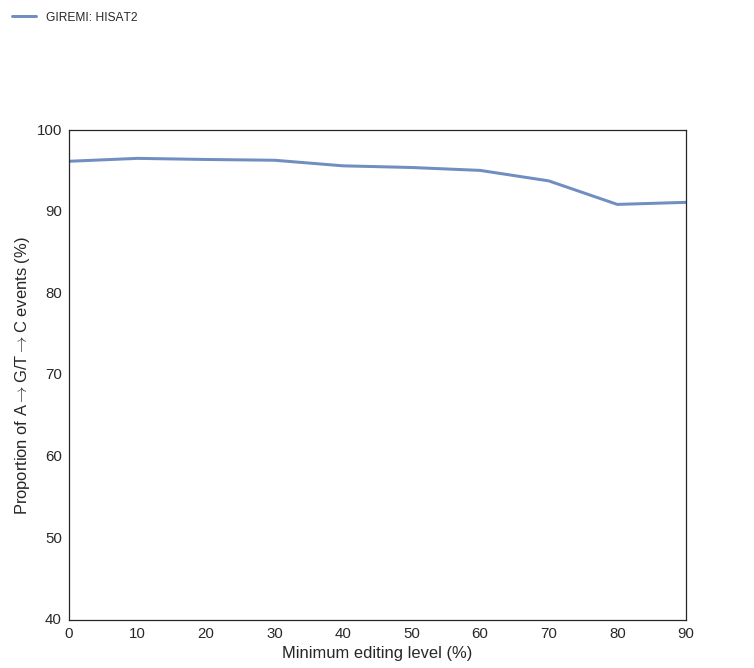

In [22]:
sns.set(style="white",font_scale=1.5)    
fig, ax = plt.subplots(figsize=(10,8))
levels=np.arange(0,100,10)
my_dist=pred_edited
etypes=my_dist['all']["types"]                
ratios=np.array(map(int,my_dist['all']["ratio"]))
E=[]
for level in levels:
    es=[etypes[i] for i in range(len(ratios)) if ratios[i]>level]
    E.append((es.count("AG")+es.count("TC"))/float(len(es)+0.00001)*100)
rects1 = ax.plot(levels,E, alpha=0.8,
                 label="%s: %s"%(editor,tool), linewidth=3)
ax.set_ylim([40,100])
ax.set_xlabel("Minimum editing level (%)")
ax.set_ylabel(r"Proportion of A$\rightarrow$G/T$\rightarrow$C events (%)")
plt.tight_layout()
ax.legend(bbox_to_anchor=(-.1, 1.15, 1.2, .102), loc=2,ncol=4,
  mode="expand", borderaxespad=0.,frameon=False,fontsize=12)
